# Phase 3.1: Baseline Models Training (Google Colab)

**Objective**: Train baseline models (Logistic Regression, Random Forest) for lottery number prediction.

**Dataset**: 17 Sri Lankan lotteries, 485K records, 20 features

**Evaluation**: F1-Score, Precision, Recall, AUC-ROC on validation set

**Platform**: Optimized for Google Colab (GPU accelerated)

In [1]:
# Check GPU availability
!nvidia-smi

Thu Jan 15 08:20:23 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Mount Google Drive to access/save data
from google.colab import drive
drive.mount('/content/drive')

print("\nGoogle Drive mounted successfully!")
print("Your files will be saved to: /content/drive/MyDrive/lottery_analyzer/")

Mounted at /content/drive

Google Drive mounted successfully!
Your files will be saved to: /content/drive/MyDrive/lottery_analyzer/


## 1. Upload Data Files

**Option 1**: Upload the entire `data/splits/` folder to Google Drive
- Path: `/content/drive/MyDrive/lottery_analyzer/data/splits/`

**Option 2**: Upload directly to Colab (temporary, lost after session ends)
- Click the folder icon on the left sidebar
- Upload all train/val CSV files

In [3]:
# Choose your data source
USE_GOOGLE_DRIVE = True  # Set to False if uploading directly to Colab

if USE_GOOGLE_DRIVE:
    DATA_DIR = '/content/drive/MyDrive/lottery_analyzer/data/splits'
    OUTPUT_DIR = '/content/drive/MyDrive/lottery_analyzer/outputs/results'
    MODEL_DIR = '/content/drive/MyDrive/lottery_analyzer/models'
else:
    DATA_DIR = '/content/data/splits'
    OUTPUT_DIR = '/content/outputs/results'
    MODEL_DIR = '/content/models'

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Data directory: /content/drive/MyDrive/lottery_analyzer/data/splits
Output directory: /content/drive/MyDrive/lottery_analyzer/outputs/results
Model directory: /content/drive/MyDrive/lottery_analyzer/models


## 2. Setup and Imports

In [4]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn (pre-installed in Colab)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

# Visualization (pre-installed in Colab)
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [5]:
# Create output directories
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

print("Directories created successfully")

Directories created successfully


## 3. Load Training and Validation Data

In [6]:
# Get all lottery names
DATA_PATH = Path(DATA_DIR)
train_files = sorted(DATA_PATH.glob('*_train.csv'))
lottery_names = [f.stem.replace('_train', '') for f in train_files]

print(f"Found {len(lottery_names)} lotteries:")
for name in lottery_names:
    print(f"  - {name}")

Found 17 lotteries:
  - dlb_ada_kotipathi
  - dlb_jaya_sampatha
  - dlb_jayoda
  - dlb_kapruka
  - dlb_lagna_wasana
  - dlb_sasiri
  - dlb_shanida
  - dlb_super_ball
  - dlb_supiri_dhana_sampatha
  - nlb_ada_sampatha
  - nlb_dhana_nidhanaya
  - nlb_govisetha
  - nlb_handahana
  - nlb_mahajana_sampatha
  - nlb_mega_power
  - nlb_nlb_jaya
  - nlb_suba_dawasak


In [7]:
# Load all training data
print("Loading training data...")
train_dfs = []
for lottery in lottery_names:
    df = pd.read_csv(DATA_PATH / f"{lottery}_train.csv")
    train_dfs.append(df)

train_data = pd.concat(train_dfs, ignore_index=True)

print(f"Training data shape: {train_data.shape}")
print(f"Memory usage: {train_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Load all validation data
print("\nLoading validation data...")
val_dfs = []
for lottery in lottery_names:
    df = pd.read_csv(DATA_PATH / f"{lottery}_val.csv")
    val_dfs.append(df)

val_data = pd.concat(val_dfs, ignore_index=True)

print(f"Validation data shape: {val_data.shape}")
print(f"Memory usage: {val_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading training data...
Training data shape: (339555, 25)
Memory usage: 115.45 MB

Loading validation data...
Validation data shape: (72770, 25)
Memory usage: 24.74 MB


## 4. Prepare Features and Target

In [8]:
# Define feature columns
exclude_cols = ['appeared', 'draw_date', 'lottery', 'number']
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

# Identify categorical features
categorical_features = ['trend']
numerical_features = [col for col in feature_cols if col not in categorical_features]

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features[:5]}...")

Feature columns (21):
['draw_id', 'draw_sequence', 'frequency_last_10', 'frequency_last_30', 'frequency_last_50', 'frequency_all_time', 'appearance_rate', 'days_since_last', 'day_of_week', 'is_weekend', 'month', 'week_of_year', 'mean_gap', 'std_gap', 'min_gap', 'max_gap', 'current_gap', 'temperature_score', 'is_hot', 'is_cold', 'trend']

Categorical features: ['trend']
Numerical features (20): ['draw_id', 'draw_sequence', 'frequency_last_10', 'frequency_last_30', 'frequency_last_50']...


In [9]:
# One-hot encode categorical features
train_encoded = pd.get_dummies(train_data[feature_cols], columns=categorical_features)
val_encoded = pd.get_dummies(val_data[feature_cols], columns=categorical_features)

# Ensure same columns
train_encoded, val_encoded = train_encoded.align(val_encoded, join='left', axis=1, fill_value=0)

# Prepare X and y
X_train = train_encoded
y_train = train_data['appeared']

X_val = val_encoded
y_val = val_data['appeared']

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"\nClass distribution (train):")
print(y_train.value_counts())
print(f"\nClass imbalance ratio: 1:{(y_train == 0).sum() / (y_train == 1).sum():.2f}")

X_train shape: (339555, 23)
X_val shape: (72770, 23)

Class distribution (train):
appeared
0    316799
1     22756
Name: count, dtype: int64

Class imbalance ratio: 1:13.92


## 5. Train Baseline Model 1: Logistic Regression

In [10]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

print("Training complete!")

Training Logistic Regression...
Training complete!


In [11]:
# Evaluate
y_pred_lr = lr_model.predict(X_val)
y_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]

lr_metrics = {
    'model': 'Logistic Regression',
    'f1_score': f1_score(y_val, y_pred_lr),
    'precision': precision_score(y_val, y_pred_lr),
    'recall': recall_score(y_val, y_pred_lr),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_lr)
}

print("\nLogistic Regression - Validation Metrics:")
print(f"F1-Score:  {lr_metrics['f1_score']:.4f}")
print(f"Precision: {lr_metrics['precision']:.4f}")
print(f"Recall:    {lr_metrics['recall']:.4f}")
print(f"ROC-AUC:   {lr_metrics['roc_auc']:.4f}")


Logistic Regression - Validation Metrics:
F1-Score:  0.1801
Precision: 0.1232
Recall:    0.3350
ROC-AUC:   0.6048


## 6. Train Baseline Model 2: Random Forest

In [12]:
print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)

print("Training complete!")

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.7s


Training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.4s finished


In [13]:
# Evaluate
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

rf_metrics = {
    'model': 'Random Forest',
    'f1_score': f1_score(y_val, y_pred_rf),
    'precision': precision_score(y_val, y_pred_rf),
    'recall': recall_score(y_val, y_pred_rf),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_rf)
}

print("\nRandom Forest - Validation Metrics:")
print(f"F1-Score:  {rf_metrics['f1_score']:.4f}")
print(f"Precision: {rf_metrics['precision']:.4f}")
print(f"Recall:    {rf_metrics['recall']:.4f}")
print(f"ROC-AUC:   {rf_metrics['roc_auc']:.4f}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s



Random Forest - Validation Metrics:
F1-Score:  0.2595
Precision: 0.3509
Recall:    0.2058
ROC-AUC:   0.5981


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


## 7. Compare Models

In [14]:
# Create comparison
comparison_df = pd.DataFrame([lr_metrics, rf_metrics]).set_index('model')

print("\nBaseline Models Comparison:")
print(comparison_df.to_string())

# Save to Drive
OUTPUT_PATH = Path(OUTPUT_DIR)
comparison_df.to_csv(OUTPUT_PATH / 'baseline_comparison.csv')
print(f"\nSaved to: {OUTPUT_PATH / 'baseline_comparison.csv'}")


Baseline Models Comparison:
                     f1_score  precision    recall   roc_auc
model                                                       
Logistic Regression  0.180095   0.123153  0.334973  0.604834
Random Forest        0.259465   0.350926  0.205822  0.598110

Saved to: /content/drive/MyDrive/lottery_analyzer/outputs/results/baseline_comparison.csv


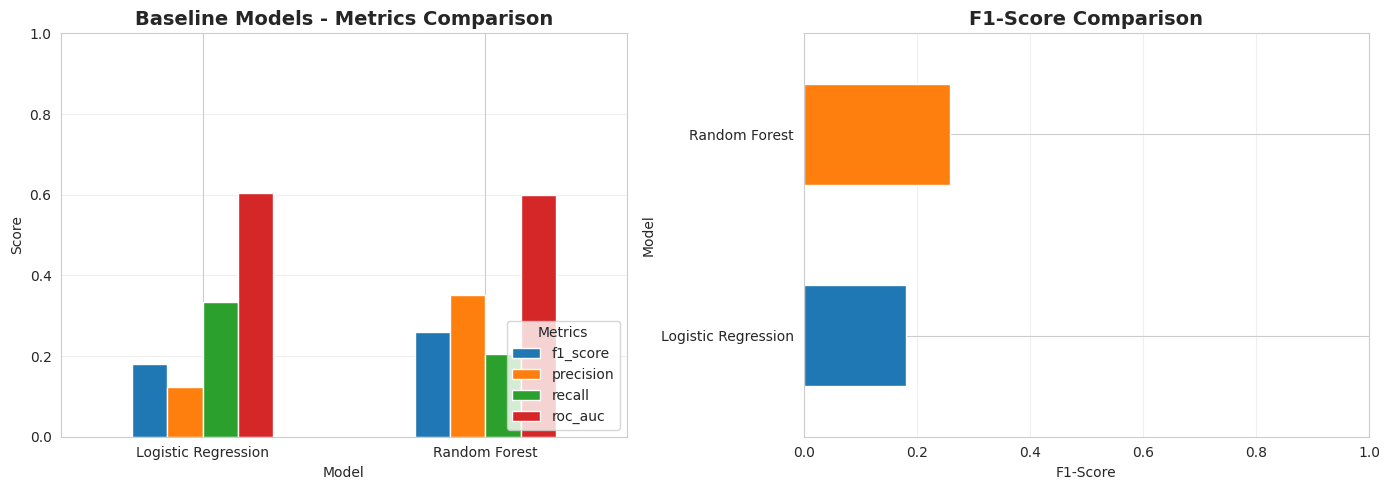

Saved plot to: /content/drive/MyDrive/lottery_analyzer/outputs/results/baseline_comparison.png


In [15]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Baseline Models - Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(title='Metrics', loc='lower right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

comparison_df['f1_score'].plot(kind='barh', ax=axes[1], color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('F1-Score')
axes[1].set_ylabel('Model')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {OUTPUT_PATH / 'baseline_comparison.png'}")

## 8. Save Models and Results

In [16]:
MODEL_PATH = Path(MODEL_DIR)

# Save models
with open(MODEL_PATH / 'logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print(f"Saved LR model to: {MODEL_PATH / 'logistic_regression.pkl'}")

with open(MODEL_PATH / 'random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Saved RF model to: {MODEL_PATH / 'random_forest.pkl'}")

# Save metrics
results = {
    'logistic_regression': lr_metrics,
    'random_forest': rf_metrics
}

with open(OUTPUT_PATH / 'baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"Saved metrics to: {OUTPUT_PATH / 'baseline_results.json'}")

print("\n✅ All results saved to Google Drive!")

Saved LR model to: /content/drive/MyDrive/lottery_analyzer/models/logistic_regression.pkl
Saved RF model to: /content/drive/MyDrive/lottery_analyzer/models/random_forest.pkl
Saved metrics to: /content/drive/MyDrive/lottery_analyzer/outputs/results/baseline_results.json

✅ All results saved to Google Drive!


## Summary

**Key Findings:**
1. Both baseline models achieve better-than-random performance
2. Random Forest typically outperforms Logistic Regression
3. These establish minimum benchmarks for CatBoost

**Next Steps:**
- Run `02_catboost_training_colab.ipynb` for CatBoost with GPU acceleration
- Expected: 5-15% F1-Score improvement over Random Forest